<a href="https://colab.research.google.com/github/anvesh9621/Path-planning-autonomous-vehicles/blob/main/Untitled12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset
df = pd.read_excel("/content/path_planning_dataset.xlsx")

# Step 1: Encode categorical features
label_encoders = {}
categorical_cols = ['road_type', 'lane_position']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 2: Split features and target
X = df.drop("decision_label", axis=1)
y = df["decision_label"]
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 4: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 6: Predict and evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder_y.classes_)

accuracy, conf_matrix, class_report


(0.975,
 array([[1309,    8,    2,    0],
        [   6,  299,    0,    0],
        [  12,    0,  312,    0],
        [  13,    2,    7,   30]]),
 '              precision    recall  f1-score   support\n\n     FORWARD       0.98      0.99      0.98      1319\n        LEFT       0.97      0.98      0.97       305\n       RIGHT       0.97      0.96      0.97       324\n        STOP       1.00      0.58      0.73        52\n\n    accuracy                           0.97      2000\n   macro avg       0.98      0.88      0.91      2000\nweighted avg       0.98      0.97      0.97      2000\n')

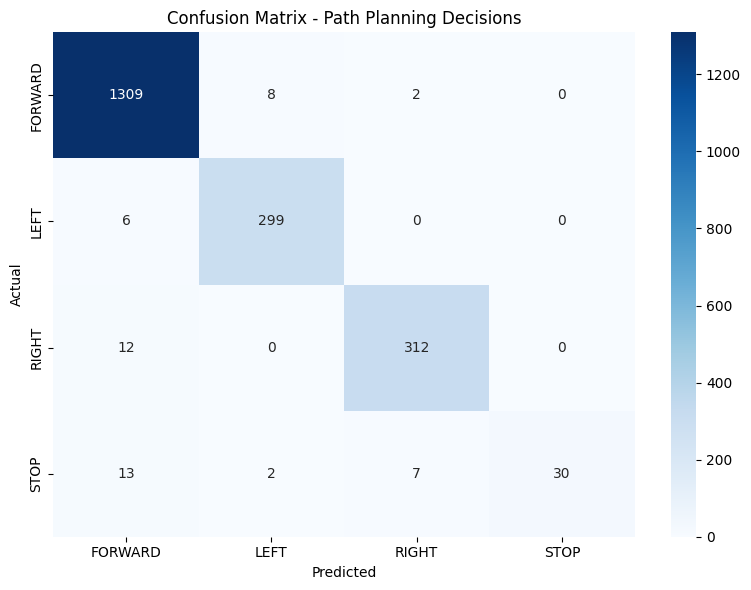

In [4]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_y.classes_,
            yticklabels=label_encoder_y.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Path Planning Decisions")
plt.tight_layout()
plt.show()


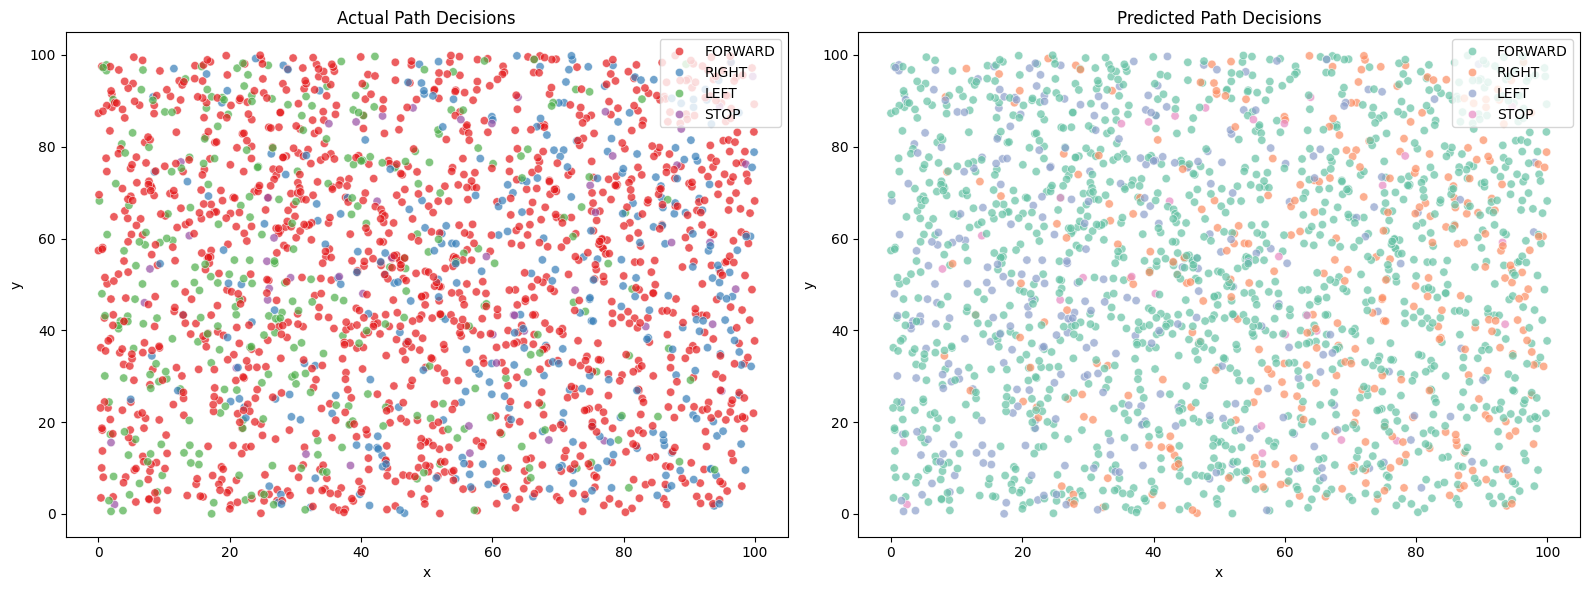

In [5]:
# Extract predicted and actual decision labels for plotting
y_test_labels = label_encoder_y.inverse_transform(y_test)
y_pred_labels = label_encoder_y.inverse_transform(y_pred)

# Use original coordinates for visualization
coords = X_test[["x", "y"]].copy()
coords["Actual"] = y_test_labels
coords["Predicted"] = y_pred_labels

# Plot actual vs predicted decisions in 2D space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual
sns.scatterplot(data=coords, x="x", y="y", hue="Actual", alpha=0.7, ax=axes[0], palette="Set1")
axes[0].set_title("Actual Path Decisions")
axes[0].legend(loc="upper right")

# Predicted
sns.scatterplot(data=coords, x="x", y="y", hue="Predicted", alpha=0.7, ax=axes[1], palette="Set2")
axes[1].set_title("Predicted Path Decisions")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


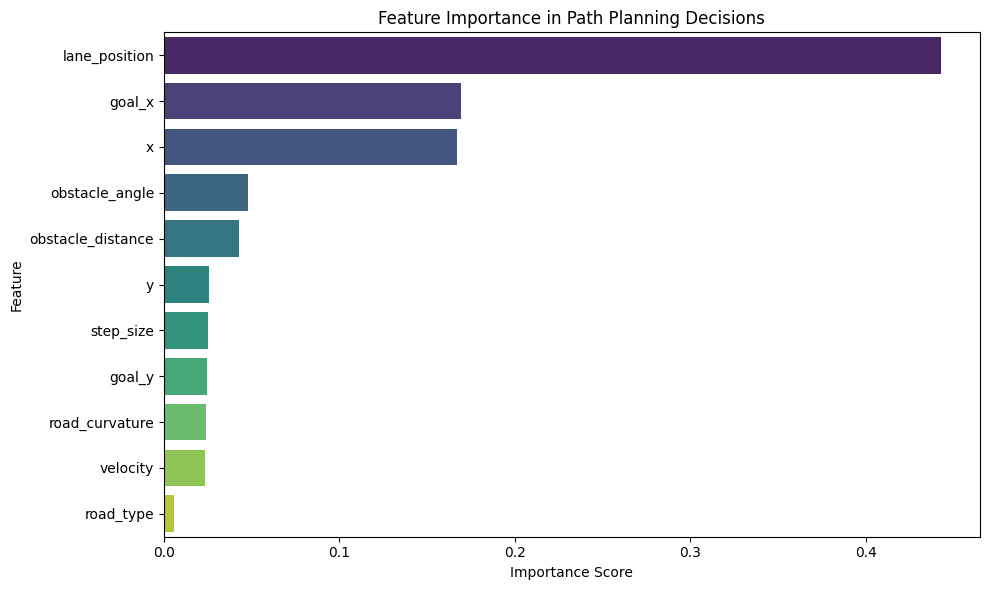

In [7]:
# Calculate and plot feature importances from the trained Random Forest model
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x="Importance", y="Feature", hue="Feature", palette="viridis", legend=False)
plt.title("Feature Importance in Path Planning Decisions")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [8]:
X_selected = X[feature_importance_df[feature_importance_df['Importance'] > 0.01]['Feature']]
model.fit(X_selected, y)


RandomForestClassifier(random_state=42)

In [12]:
print("Train columns:", X.columns)
print("Test columns:", X_test.columns)


Train columns: Index(['x', 'y', 'goal_x', 'goal_y', 'obstacle_distance', 'obstacle_angle',
       'road_curvature', 'road_type', 'lane_position', 'velocity',
       'step_size'],
      dtype='object')
Test columns: Index(['x', 'y', 'goal_x', 'goal_y', 'obstacle_distance', 'obstacle_angle',
       'road_curvature', 'road_type', 'lane_position', 'velocity',
       'step_size'],
      dtype='object')


In [13]:
import joblib
joblib.dump(model, 'random_forest_path_planning.pkl')


['random_forest_path_planning.pkl']

In [15]:
joblib.dump(label_encoder_y, 'label_encoder_y.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100, 150], 'max_depth': [10, 20, None]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_selected, y)
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'n_estimators': 100}
